## Import libraries

In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import osmnx as ox
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Polygon, MultiLineString, Point, LineString

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/usr/local/python/lib/python3.10/site-packages/osmnx/utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(


In [2]:
save = True
save_space = True

## Required data

### Required data - Area of Interest

In [3]:
city = 'Aguascalientes'

# Source Data
schema = 'metropolis'
folder = 'metro_gdf'

# Downloads hexagons within 'city'
query = f"SELECT * FROM {schema}.{folder} WHERE \"city\" LIKE \'{city}\'"
mun_gdf = aup.gdf_from_query(query, geometry_col='geometry')

#Show
print(mun_gdf.shape)
mun_gdf.head(2)

(3, 6)


,CVEGEO,CVE_ENT,CVE_MUN,NOMGEO,geometry,city
0,01001,01,001,Aguascalientes,"POLYGON ((-102.10641 22.06035, -102.10368 22.0...",Aguascalientes
1,01005,01,005,Jesús María,"POLYGON ((-102.33568 22.05067, -102.33348 22.0...",Aguascalientes


<Axes: >

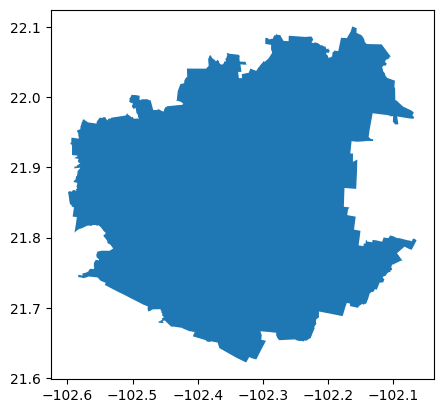

In [4]:
mun_gdf = mun_gdf.set_crs("EPSG:4326")
aoi = mun_gdf.dissolve()
aoi = aoi[['city','geometry']]

#Show
aoi.plot()

### Required data - nodes and edges from notebook prox_loading_osmnx 1 [Script 07-download_osmnx]

In [5]:
nodes = gpd.read_file("../../data/external/temporal_fromjupyter/nodes.gpkg")

#Show
print(nodes.shape)
nodes.head(2)

(57478, 5)


,osmid,x,y,street_count,geometry
0,301189389,-102.342212,21.848544,4,POINT (-102.34221 21.84854)
1,301189406,-102.350222,21.850815,3,POINT (-102.35022 21.85082)


In [6]:
#poly_wkt = aoi.dissolve().geometry.to_wkt()[0]
# Creates query to download nodes
#query = f"SELECT * FROM osmnx.nodes WHERE ST_Intersects(geometry, \'SRID=4326;{poly_wkt}\')"
#nodes = aup.gdf_from_query(query, geometry_col='geometry')

#Show
#print(nodes.shape)
#nodes.head(2)

In [7]:
edges = gpd.read_file("../../data/external/temporal_fromjupyter/edges.gpkg")

#Show
print(edges.shape)
edges.head(2)

(135456, 18)


,osmid,v,u,key,oneway,lanes,name,highway,maxspeed,length,bridge,ref,junction,tunnel,access,width,service,geometry
0,713153965,1408187972,301189389,0,False,NaN,Prolongación Constitución,residential,NaN,13.812,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"LINESTRING (-102.34221 21.84854, -102.34219 21..."
1,715583649,9370947312,301189389,0,True,2,Avenida Siglo XXI,trunk,NaN,412.235,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"LINESTRING (-102.34221 21.84854, -102.34600 21..."


In [8]:
#poly_wkt = aoi.dissolve().geometry.to_wkt()[0]
# Creates query to download edges
#query = f"SELECT * FROM osmnx.edges WHERE ST_Intersects(geometry, \'SRID=4326;{poly_wkt}\')"
#edges = aup.gdf_from_query(query, geometry_col='geometry')

#Show
#print(edges.shape)
#edges.head(2)

### Required data - Points of interest

In [9]:
poly_wkt = aoi.dissolve().geometry.to_wkt()[0]

### Required data - Points of interest - DENUE

In [10]:
# Creates query to download DENUE from the metropolitan area or capital
query = f"SELECT * FROM denue.denue_2022 WHERE ST_Intersects(geometry, \'SRID=4326;{poly_wkt}\')"
denue = aup.gdf_from_query(query, geometry_col='geometry')

denue = denue[['codigo_act', 'geometry']]

#Show
print(denue.shape)
denue.head(2)

(52473, 2)


,codigo_act,geometry
0,436112,POINT (-102.28996 21.90149)
1,436112,POINT (-102.28880 21.99203)


In [11]:
# Set denue amenities of interest
denue_amenities = {'Preescolar':[611111, 611112], 
                   'Primaria':[611121, 611122],
                   'Secundaria':[611131, 611132], 
                   'denue_guarderias':[624411, 624412],
                   'denue_dif':[931610],
                   'denue_supermercado':[462111],'denue_abarrotes':[461110], 'denue_carnicerias': [461121, 461122, 461123],
                   'denue_peluqueria':[812110],
                   'denue_farmacias':[464111, 464112],
                   'denue_ferreteria_tlapaleria':[467111],'denue_art_limpieza':[467115],
                   'denue_ropa':[463211, 463212, 463213, 463215, 463216, 463218],'denue_calzado':[463310], 'denue_muebles':[466111, 466112, 466113, 466114],'denue_lavanderia':[812210],'denue_revistas_periodicos':[465313],'denue_pintura':[467113],
                   'denue_restaurante_insitu':[722511, 722512, 722513, 722514, 722519],'denue_restaurante_llevar':[722516, 722518, 722517],'denue_bares':[722412],'denue_cafe':[722515],
                   'denue_parque_natural':[712190],
                   'denue_cines':[512130],'denue_museos':[712111, 712112]}

# Iterate over denue_amenities and filter denue gdf
denue_pois = gpd.GeoDataFrame()

for amenity in denue_amenities.values():
    for code in range(len(amenity)):
        denue_tmp = denue.loc[denue['codigo_act'] == f'{amenity[code]}']
        denue_pois = pd.concat([denue_pois,denue_tmp])

# Format
denue_pois = denue_pois.rename(columns={'codigo_act':'code'})

# Saves space in disk if instructed
if save_space:
    del denue
    del denue_tmp
        
# Show
print(denue_pois.shape)
denue_pois.head(2)

(20279, 2)


,code,geometry
27063,611111,POINT (-102.32776 21.94211)
27082,611111,POINT (-102.26791 21.92303)


### Required data - Points of interest - CLUES

In [12]:
# Creates query to download DENUE from the metropolitan area or capital
query = f"SELECT * FROM denue.clues WHERE ST_Intersects(geometry, \'SRID=4326;{poly_wkt}\')"
clues = aup.gdf_from_query(query, geometry_col='geometry')

# Set and filter CLUES amenities of interest
clues_pois = clues.loc[clues['nivel_atencion'] == 'PRIMER NIVEL']

#Format
clues_pois.loc[:,'code'] = 8610
clues_pois = clues_pois[['code','geometry']]

# Saves space in disk if instructed
if save_space:
    del clues

# Show
print(clues_pois.shape)
clues_pois.head(2)

(132, 2)


/usr/local/python/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,code,geometry
0,8610,POINT (-102.27370 21.72520)
1,8610,POINT (-102.37120 21.75750)


### Required data - Points of interest - SIP

In [13]:
# Creates query to download DENUE from the metropolitan area or capital
query = f"SELECT * FROM denue.sip_2020 WHERE ST_Intersects(geometry, \'SRID=4326;{poly_wkt}\')"
sip = aup.gdf_from_query(query, geometry_col='geometry')

sip_amenities = {'GEOGRAFICO':['Mercado','Plaza'], 
                 'TIPO':['Cancha','Unidad Deportiva','Parque']}

sip_amenities_codes = {'Mercado':4721,
                       'Plaza':9321,
                       'Cancha':9311,
                       'Unidad Deportiva':9311,
                       'Parque':9321}
                 
# Iterate over sip_amenities and filter sip gdf
sip_pois = gpd.GeoDataFrame()

for col in sip_amenities:
    for amenity in sip_amenities[col]:
        sip_tmp = sip.loc[sip[col] == amenity]
        sip_tmp.loc[:,'code'] = sip_amenities_codes[amenity]
        sip_pois = pd.concat([sip_pois,sip_tmp])

#Format
sip_pois = sip_pois[['code','geometry']]

# Saves space in disk if instructed
if save_space:
    del sip

# Show
print(sip_pois.shape)
sip_pois.head(2)

(182, 2)


/usr/local/python/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/python/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/python/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

,code,geometry
314,4721,POINT (-102.26894 21.85950)
350,4721,POINT (-102.25365 21.89700)


In [14]:
pois = pd.concat([denue_pois,clues_pois,sip_pois])

# Show
print(pois.shape)
pois.head(2)

(20593, 2)


,code,geometry
27063,611111,POINT (-102.32776 21.94211)
27082,611111,POINT (-102.26791 21.92303)


## Step 2: define graph_from_hippo without loading from a database

### Necessary definitions - graph_from_hippo

In [15]:
def graph_from_nodes_and_edges(gdf, nodes, edges):
    # ------------------------------------------------------ CODE CHANGE NEEDED: INSTEAD OF QUERRING FROM DB FROM A POLY_WKT, OVERLAY IS USED.
    # Query edges intersecting area of interest
    edges_gdf = gpd.overlay(gdf,edges,keep_geom_type=False)

    # Delete useless columns resulting from overlay
    edges_columns = [
        "osmid",
        "v",
        "u",
        "key",
        "oneway",
        "lanes",
        "name",
        "highway",
        "maxspeed",
        "length",
        "geometry",
        "bridge",
        "ref",
        "junction",
        "tunnel",
        "access",
        "width",
        "service",
    ]

    edges_gdf = edges_gdf[edges_columns]

    # Find nodes belonging to those querried edges
    nodes_id = list(edges_gdf.v.unique())
    u = list(edges_gdf.u.unique())
    nodes_id.extend(u)
    myset = set(nodes_id)
    nodes_id = list(myset)

    # ------------------------------------------------------ CODE CHANGE NEEDED: INSTEAD OF QUERRING FROM DB WHERE osmid IN {str(tuple(nodes_id))}, isin(nodes_id list) IS USED.
    # Query those nodes
    idx = nodes['osmid'].isin(nodes_id)
    nodes_gdf = nodes.loc[idx]

    # Drop duplicates
    #                                       ----------------------------------- ERROR, CONSULTAR CON EDGAR: ---------- Usando este method sale "TypeError: unhashable type: 'list'".
    edges_gdf.drop_duplicates(inplace=True) 
    #edges_gdf = edges_gdf.loc[edges_gdf.astype(str).drop_duplicates().index]
    nodes_gdf.drop_duplicates(inplace=True)

    # Format
    nodes_gdf = nodes_gdf.set_index('osmid')
    edges_gdf = edges_gdf.set_index(["u", "v", "key"])

    nodes_gdf = nodes_gdf.set_crs("EPSG:4326")
    edges_gdf = edges_gdf.set_crs("EPSG:4326")

    #-----------------------------------------------------------------------------------------------------------------------------------------------------
    print("Querried and formated nodes and edges within area of interest.")
    #-----------------------------------------------------------------------------------------------------------------------------------------------------

    # Making sure all nodes belonging to edges_gdf are present in nodes_gdf
    nodes_tmp = nodes_gdf.reset_index().copy()
    edges_tmp = edges_gdf.reset_index().copy()

    # Current nodes in nodes_gdf
    nodes_dict = nodes_tmp.to_dict()

    # U nodes
    # U nodes that are in edges_tmp but not in nodes_tmp
    from_osmid = list(set(edges_tmp['u'].to_list()).difference(set(nodes_tmp.osmid.to_list())))

    # Iterating over each missing U node and adding its data to nodes_dict
    for i in from_osmid:
        row = edges_tmp.loc[(edges_tmp.u==i)].iloc[0]
        coords = [(coords) for coords in list(row['geometry'].coords)]
        first_coord, last_coord = [ coords[i] for i in (0, -1) ]

        nodes_dict['osmid'][len(nodes_dict['osmid'])] = i
        nodes_dict['x'][len(nodes_dict['x'])] = first_coord[0]
        nodes_dict['y'][len(nodes_dict['y'])] = first_coord[1]
        nodes_dict['street_count'][len(nodes_dict['street_count'])] = np.nan
        nodes_dict['geometry'][len(nodes_dict['geometry'])] = Point(first_coord)

    # V nodes
    # V nodes that are in edges_tmp but not in nodes_dict                                                      #Duda para Edgar: ¿Por qué en U nodes revisamos nodes_tmp pero en V nodes revisamos nodes_dict?
    to_osmid = list(set(edges_tmp['v'].to_list()).difference(set(list(nodes_dict['osmid'].values()))))

    # Iterating over each missing V node and adding its data to nodes_dict
    for i in to_osmid:
        row = edges_tmp.loc[(edges_tmp.v==i)].iloc[0]
        coords = [(coords) for coords in list(row['geometry'].coords)]
        first_coord, last_coord = [ coords[i] for i in (0, -1) ]

        nodes_dict['osmid'][len(nodes_dict['osmid'])] = i
        nodes_dict['x'][len(nodes_dict['x'])] = last_coord[0]
        nodes_dict['y'][len(nodes_dict['y'])] = last_coord[1]
        nodes_dict['street_count'][len(nodes_dict['street_count'])] = np.nan
        nodes_dict['geometry'][len(nodes_dict['geometry'])] = Point(last_coord)

    # Rewriting nodes_gdf from updated nodes_dict
    nodes_tmp = pd.DataFrame.from_dict(nodes_dict)
    nodes_tmp = gpd.GeoDataFrame(nodes_tmp, crs="EPSG:4326", geometry='geometry')
    nodes_gdf = nodes_tmp.copy()
    nodes_gdf.set_index('osmid',inplace=True)    

    #-----------------------------------------------------------------------------------------------------------------------------------------------------
    print("Missing nodes from edges added to nodes gdf.")
    #-----------------------------------------------------------------------------------------------------------------------------------------------------

    G = ox.graph_from_gdfs(nodes_gdf, edges_gdf)

    #-----------------------------------------------------------------------------------------------------------------------------------------------------
    print("Created graph.")
    #-----------------------------------------------------------------------------------------------------------------------------------------------------
    
    return G, nodes_gdf, edges_gdf

In [16]:
def pois_nodes_distance(aoi, nodes, edges, pois):
    G, nodes_gdf, edges_gdf = graph_from_nodes_and_edges(aoi, nodes, edges)

    #-----------------------------------------------------------------------------------------------------------------------------------------------------
    print("Created network.")
    #-----------------------------------------------------------------------------------------------------------------------------------------------------

    pois = pois.set_crs("EPSG:4326")
    nodes = nodes.set_crs("EPSG:4326")
    edges = edges.set_crs("EPSG:4326")

    nearest = aup.find_nearest(G, nodes, pois, return_distance= True)
    
    #-----------------------------------------------------------------------------------------------------------------------------------------------------
    print("Calculated distances from pois to nearest node.")
    #-----------------------------------------------------------------------------------------------------------------------------------------------------
    
    return nearest

In [17]:
nearest = pois_nodes_distance(aoi, nodes, edges, pois)

/tmp/ipykernel_19910/3734518090.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nodes_gdf.drop_duplicates(inplace=True)


Querried and formated nodes and edges within area of interest.
Missing nodes from edges added to nodes gdf.
Created graph.
Created network.
Calculated distances from pois to nearest node.


In [18]:
#Show
print(nearest.shape)
nearest.head(2)

(20593, 4)


,code,geometry,osmid,distance_node
27063,611111,POINT (-102.32776 21.94211),5897,8.434524
27082,611111,POINT (-102.26791 21.92303),28485,19.788102


In [19]:
if save:
    nearest.to_file('../../data/external/temporal_fromjupyter/pois_distance_node.gpkg', driver='GPKG')